In [1]:
# sigmoid curve fitting is from the https://gist.github.com/andrewgiessel/5684769
# good discussion here:  http://stackoverflow.com/questions/4308168/sigmoidal-regression-with-scipy-numpy-python-etc
# https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html
# https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ConstantKernel.html

## 1. Import dependecies and define fuctions

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import warnings
warnings.filterwarnings("ignore")

In [3]:
# install lmfit regression module
#! pip install lmfit

# Import lmfit module
from lmfit.models import ConstantModel, StepModel
from lmfit import Model, Minimizer, Parameters, report_fit

In [4]:
# Define the sigmoid function
# define h : Interval, c: minimum, a:logistic growth rate or steepness, x0: x_mid point 
def sigmoid(x, h, a, x0, c):
    return h / (1. + np.exp(-a * (x - x0))) + c

# create a fit Model that wraps the sigmoid function
smodel = Model(sigmoid)
# assign initial values of parameters and other attributes
params = smodel.make_params(h=5, a=1, x0=0, c=10)

## 2. Defne fuction for gaussian fitting

In [5]:
# definition of sigmoid and gaussian fuctions
def fit_sig(x, y, y_err):
    
    # nonlinear least squares curve fitting with sigmoid fuction

    OP= smodel.fit(y, params, bounds=([-20, -10, -0.7, 0], [20, 10, 0.7, 80]), x=x)

    #print parameters
    # print(OP.fit_report())
    print('-------------------------------')
    print('Parameter    Value       Stderr')
    for name, param in OP.params.items():
        print('{!s:7s} {:11.5f} {:11.5f}'.format(name, param.value, param.stderr))


    # define and print the y_max, y_min, y_90, and y_10 values
    y_max = OP.params['c'].value
    y_90 = OP.params['c'].value + 0.1*OP.params['h'].value
    y_10 = OP.params['c'].value + 0.9*OP.params['h'].value
    y_min = OP.params['c'].value + OP.params['h'].value
    print(f"y_max : {y_max:.3f}, y_90: {y_90:.3f},  y_10: {y_10:.3f},  y_min: {y_min:.3f}")

    # define sigmiod 90, 10% fuction.
    def fp(p) :
        f1 = sigmoid(p, OP.params['h'].value, OP.params['a'].value, OP.params['x0'].value, OP.params['c'].value) - y_90
        return f1

    def fq(q) :
        f2 = sigmoid(q, OP.params['h'].value, OP.params['a'].value, OP.params['x0'].value, OP.params['c'].value) - y_10
        return f2

    #Solving the equation (p=90%, q= 10%)
    p_sol = fsolve(fp,0)
    q_sol = fsolve(fq,0)
    x_gab = q_sol-p_sol
    R_squared = r2_score(OP.best_fit, y)
    
    print(f"x_90: {p_sol}, x_10: {q_sol}, x_gap: {x_gab}, R_2: {R_squared:.4f}")


    # Plot the function, the prediction and the 95% confidence interval based on
    # the MSE
    plt.figure(figsize=(6,3.5))
    plt.plot(x, OP.best_fit, 'b:', label=r'Sigmoid')
    plt.errorbar(x, y, y_err, fmt='r.', markersize=10, elinewidth=1, capsize=2,label='Measured value')

    plt.axvline(x=OP.params['x0'].value, color='k', linestyle='--', label='Center' )
    plt.axvline(x=p_sol, color='g', linestyle='--', label='10-90 interval')
    plt.axvline(x=q_sol, color='g', linestyle='--')
    plt.xlim([-3, 3])
    plt.legend(loc='best')
    plt.xlabel("Distance (nm)", fontsize=14)
    plt.ylabel('Concentration (%)', fontsize=14)
    plt.show()


# <end sigmoid fuction>


## 3. Import data and assign the x, y values 

In [6]:
# import csv data
df0 = pd.read_csv('Re_700_1h.csv')
print("df0_shape :", df0.shape)
df = df0.iloc[0:40]
print("df_shape :", df.shape)
df

df0_shape : (27, 9)
df_shape : (27, 9)


,distance,Ni,Ni_Err,Al,Al_Err,Cr,Cr_Err,Re,Re_Err
0,-2.300005,79.818010,0.057817,7.509637,0.037985,10.387139,0.042752,2.285214,0.020940
1,-2.100005,79.827998,0.059430,7.508455,0.038819,10.389608,0.043954,2.273939,0.021474
2,-1.900005,79.778634,0.061422,7.470338,0.040122,10.443846,0.045293,2.307183,0.022234
3,-1.700005,79.857810,0.063456,7.357619,0.041743,10.494905,0.046869,2.289666,0.022873
4,-1.500005,79.817193,0.065857,7.567684,0.043775,10.360858,0.048218,2.254265,0.023486
5,-1.300004,79.697061,0.068680,7.832487,0.046534,10.254422,0.049776,2.216030,0.024154
6,-1.100004,79.319362,0.071819,8.458996,0.049910,10.009941,0.051244,2.211702,0.025109
7,-0.900004,79.009223,0.075803,9.116080,0.054594,9.664066,0.052582,2.210631,0.026166
8,-0.700004,78.617390,0.080146,9.898038,0.059702,9.340591,0.054166,2.143981,0.026961
9,-0.500004,77.870689,0.085438,11.159069,0.066350,8.915280,0.055703,2.054962,0.027732


## 4. Obtain the interfacial width for Ni, Al, Cr, Re at 1h aging.




 Re_700_025h.csv

 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -5.26133     0.11209
a           2.49764     0.16157
x0         -0.11963     0.02999
c          78.89532     0.04400
y_max : 78.895, y_90: 78.369,  y_10: 74.160,  y_min: 73.634
x_90: [-0.99935508], x_10: [0.76008799], x_gap: [1.75944308], R_2: 0.9950


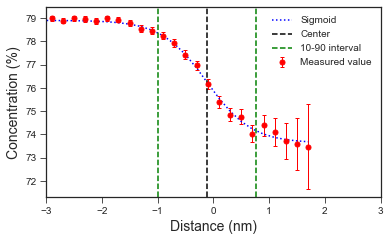


 Element Al
-------------------------------
Parameter    Value       Stderr
h           9.69319     0.15751
a           2.41001     0.11691
x0         -0.15531     0.02325
c           9.43218     0.06221
y_max : 9.432, y_90: 10.401,  y_10: 18.156,  y_min: 19.125
x_90: [-1.06701372], x_10: [0.75639953], x_gap: [1.82341326], R_2: 0.9971


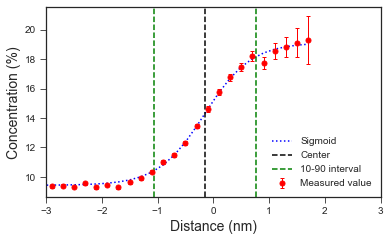


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -3.74339     0.09226
a           2.37160     0.17748
x0         -0.25118     0.03613
c           9.47440     0.03858
y_max : 9.474, y_90: 9.100,  y_10: 6.105,  y_min: 5.731
x_90: [-1.17765577], x_10: [0.67529368], x_gap: [1.85294945], R_2: 0.9932


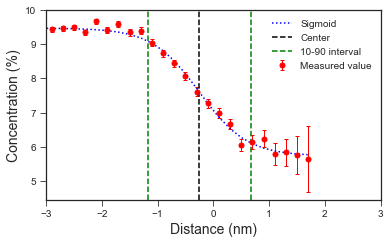


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -0.64825     0.03344
a           2.77159     0.44883
x0          0.02264     0.06826
c           2.19346     0.01253
y_max : 2.193, y_90: 2.129,  y_10: 1.610,  y_min: 1.545
x_90: [-0.77012588], x_10: [0.81540735], x_gap: [1.58553323], R_2: 0.9694


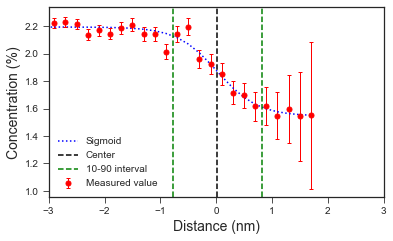




 Re_700_1h.csv

 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -5.37083     0.12982
a           2.64564     0.20818
x0         -0.30340     0.03350
c          79.93524     0.10141
y_max : 79.935, y_90: 79.398,  y_10: 75.101,  y_min: 74.564
x_90: [-1.1339126], x_10: [0.52710341], x_gap: [1.66101601], R_2: 0.9933


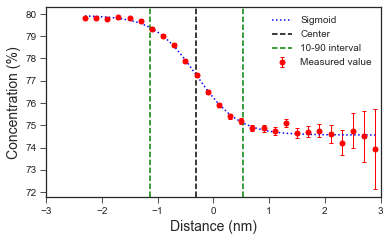


 Element Al
-------------------------------
Parameter    Value       Stderr
h          11.51540     0.15452
a           2.41710     0.10039
x0         -0.21812     0.01911
c           7.22380     0.11780
y_max : 7.224, y_90: 8.375,  y_10: 17.588,  y_min: 18.739
x_90: [-1.12715098], x_10: [0.69091432], x_gap: [1.8180653], R_2: 0.9981


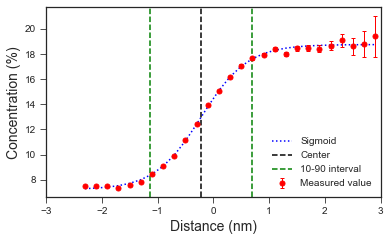


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -5.47735     0.06826
a           2.30632     0.08750
x0         -0.10915     0.01808
c          10.51353     0.05030
y_max : 10.514, y_90: 9.966,  y_10: 5.584,  y_min: 5.036
x_90: [-1.06184829], x_10: [0.84354631], x_gap: [1.9053946], R_2: 0.9984


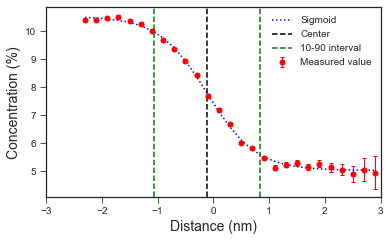


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -0.62671     0.02724
a           2.71320     0.38980
x0         -0.32043     0.05979
c           2.29015     0.02138
y_max : 2.290, y_90: 2.227,  y_10: 1.726,  y_min: 1.663
x_90: [-1.13025894], x_10: [0.48939946], x_gap: [1.6196584], R_2: 0.9779


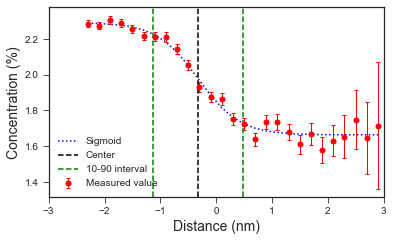




 Re_700_4h.csv

 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -5.31093     0.07673
a           2.82377     0.14867
x0         -0.15224     0.02104
c          80.20169     0.05606
y_max : 80.202, y_90: 79.671,  y_10: 75.422,  y_min: 74.891
x_90: [-0.93036004], x_10: [0.62587371], x_gap: [1.55623375], R_2: 0.9970


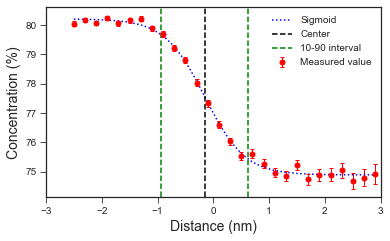


 Element Al
-------------------------------
Parameter    Value       Stderr
h          12.52184     0.12001
a           2.53107     0.08138
x0         -0.20830     0.01420
c           6.21188     0.08860
y_max : 6.212, y_90: 7.464,  y_10: 17.482,  y_min: 18.734
x_90: [-1.0764015], x_10: [0.65980205], x_gap: [1.73620355], R_2: 0.9988


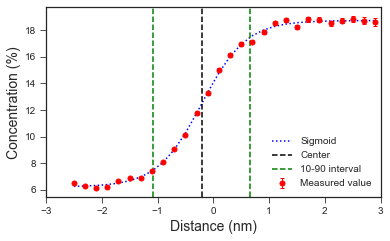


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -6.09278     0.08500
a           2.33582     0.10303
x0         -0.21584     0.02090
c          11.08143     0.06265
y_max : 11.081, y_90: 10.472,  y_10: 5.598,  y_min: 4.989
x_90: [-1.15650586], x_10: [0.72482272], x_gap: [1.88132858], R_2: 0.9978


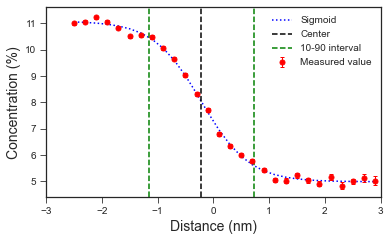


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -1.16210     0.03023
a           2.34952     0.18355
x0         -0.50453     0.03740
c           2.54610     0.02405
y_max : 2.546, y_90: 2.430,  y_10: 1.500,  y_min: 1.384
x_90: [-1.43971319], x_10: [0.43064623], x_gap: [1.87035943], R_2: 0.9930


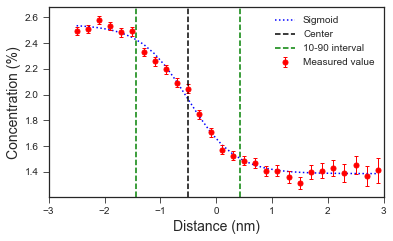




 Re_700_16h.csv

 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -4.77248     0.06092
a           3.20934     0.17963
x0          0.03238     0.01997
c          79.95614     0.04074
y_max : 79.956, y_90: 79.479,  y_10: 75.661,  y_min: 75.184
x_90: [-0.65225338], x_10: [0.71701484], x_gap: [1.36926822], R_2: 0.9967


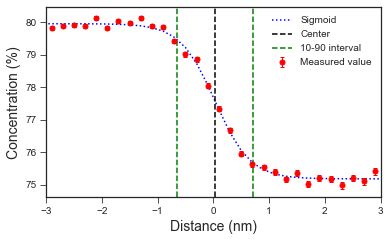


 Element Al
-------------------------------
Parameter    Value       Stderr
h          12.30840     0.06649
a           2.54905     0.05212
x0         -0.00679     0.00906
c           5.77193     0.04403
y_max : 5.772, y_90: 7.003,  y_10: 16.849,  y_min: 18.080
x_90: [-0.86877128], x_10: [0.85518235], x_gap: [1.72395363], R_2: 0.9995


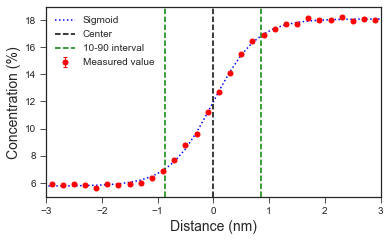


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -6.22513     0.02960
a           2.24626     0.03712
x0         -0.01096     0.00820
c          11.60280     0.01934
y_max : 11.603, y_90: 10.980,  y_10: 6.000,  y_min: 5.378
x_90: [-0.98913408], x_10: [0.9672042], x_gap: [1.95633828], R_2: 0.9996


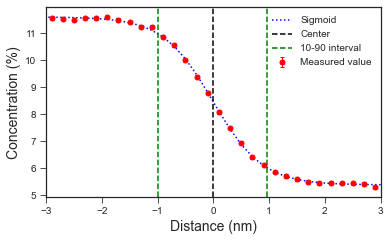


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -1.37110     0.01978
a           1.99741     0.09177
x0         -0.19098     0.02521
c           2.71350     0.01346
y_max : 2.714, y_90: 2.576,  y_10: 1.480,  y_min: 1.342
x_90: [-1.29101691], x_10: [0.90905144], x_gap: [2.20006835], R_2: 0.9971


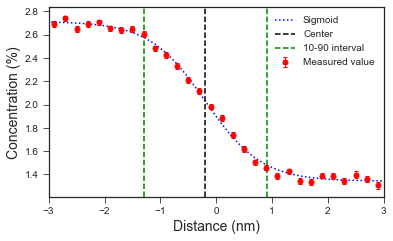




 Re_700_64h.csv

 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -4.63225     0.03392
a           3.45905     0.13426
x0         -0.40611     0.01291
c          80.14281     0.02441
y_max : 80.143, y_90: 79.680,  y_10: 75.974,  y_min: 75.511
x_90: [-1.04132315], x_10: [0.22909661], x_gap: [1.27041976], R_2: 0.9984


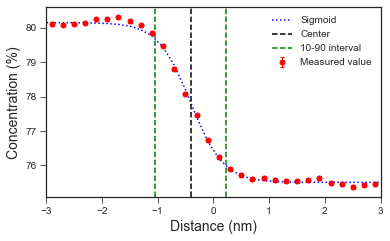


 Element Al
-------------------------------
Parameter    Value       Stderr
h          12.19063     0.02178
a           2.53479     0.01982
x0         -0.52337     0.00353
c           5.69109     0.01582
y_max : 5.691, y_90: 6.910,  y_10: 16.663,  y_min: 17.882
x_90: [-1.39020099], x_10: [0.34345506], x_gap: [1.73365604], R_2: 0.9999


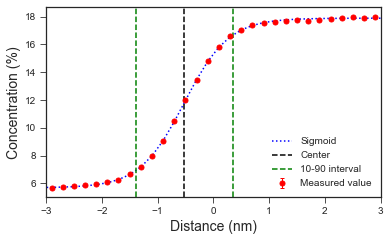


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -6.10156     0.01421
a           2.14874     0.01991
x0         -0.20651     0.00490
c          11.45896     0.00967
y_max : 11.459, y_90: 10.849,  y_10: 5.968,  y_min: 5.357
x_90: [-1.22907341], x_10: [0.81605572], x_gap: [2.04512913], R_2: 0.9999


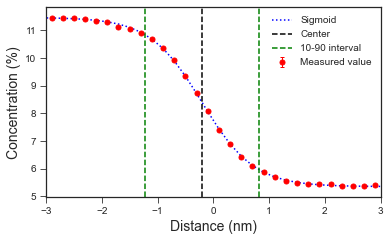


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -1.56040     0.00832
a           1.89780     0.03694
x0         -0.36161     0.01154
c           2.80554     0.00578
y_max : 2.806, y_90: 2.650,  y_10: 1.401,  y_min: 1.245
x_90: [-1.5193885], x_10: [0.79616549], x_gap: [2.315554], R_2: 0.9994


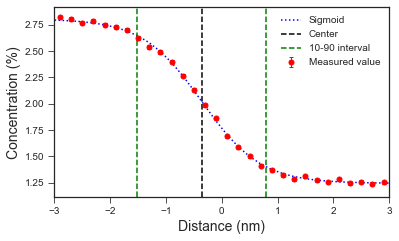




 Re_700_256h.csv

 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -4.34139     0.04241
a           4.63338     0.32437
x0          0.06428     0.01735
c          80.12384     0.02930
y_max : 80.124, y_90: 79.690,  y_10: 76.217,  y_min: 75.782
x_90: [-0.40993307], x_10: [0.53850062], x_gap: [0.94843369], R_2: 0.9959


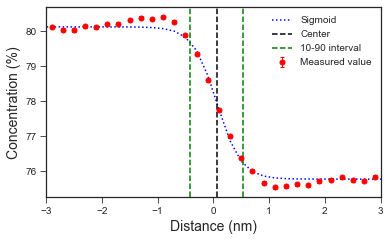


 Element Al
-------------------------------
Parameter    Value       Stderr
h          12.08908     0.01389
a           2.76694     0.01706
x0         -0.00636     0.00256
c           5.50212     0.00954
y_max : 5.502, y_90: 6.711,  y_10: 16.382,  y_min: 17.591
x_90: [-0.80046003], x_10: [0.7877357], x_gap: [1.58819572], R_2: 0.9999


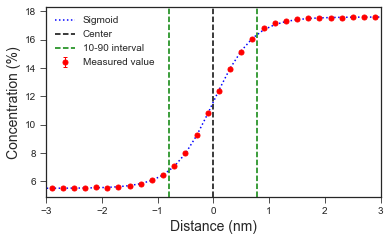


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -6.24017     0.01060
a           2.07298     0.01591
x0         -0.04973     0.00424
c          11.64385     0.00722
y_max : 11.644, y_90: 11.020,  y_10: 6.028,  y_min: 5.404
x_90: [-1.10966325], x_10: [1.01020984], x_gap: [2.11987309], R_2: 0.9999


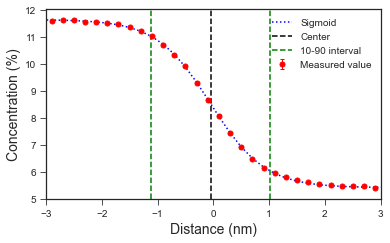


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -1.66692     0.00565
a           1.70711     0.02312
x0         -0.21097     0.00902
c           2.83930     0.00390
y_max : 2.839, y_90: 2.673,  y_10: 1.339,  y_min: 1.172
x_90: [-1.49806513], x_10: [1.07613169], x_gap: [2.57419682], R_2: 0.9996


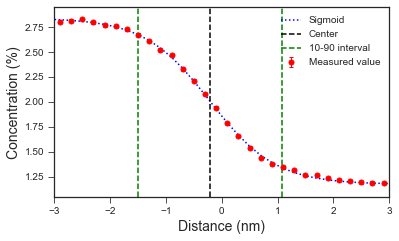




 Re_700_1024h.csv

 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -4.42920     0.04743
a           4.57293     0.34857
x0         -0.03472     0.01914
c          80.13322     0.03313
y_max : 80.133, y_90: 79.690,  y_10: 76.147,  y_min: 75.704
x_90: [-0.51520138], x_10: [0.44576858], x_gap: [0.96096996], R_2: 0.9951


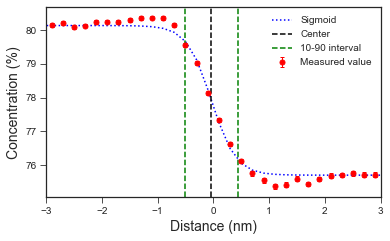


 Element Al
-------------------------------
Parameter    Value       Stderr
h          12.25446     0.02019
a           2.70628     0.02362
x0         -0.08291     0.00371
c           5.46770     0.01399
y_max : 5.468, y_90: 6.693,  y_10: 16.497,  y_min: 17.722
x_90: [-0.89480515], x_10: [0.72899464], x_gap: [1.6237998], R_2: 0.9999


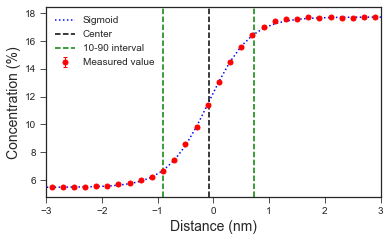


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -6.32328     0.01735
a           2.00513     0.02435
x0         -0.09988     0.00694
c          11.70276     0.01188
y_max : 11.703, y_90: 11.070,  y_10: 6.012,  y_min: 5.379
x_90: [-1.19568194], x_10: [0.99592398], x_gap: [2.19160592], R_2: 0.9997


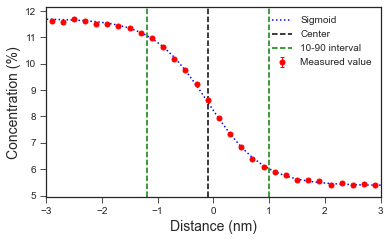


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -1.69039     0.00877
a           1.56561     0.03058
x0         -0.30400     0.01410
c           2.81773     0.00609
y_max : 2.818, y_90: 2.649,  y_10: 1.296,  y_min: 1.127
x_90: [-1.70743242], x_10: [1.09942918], x_gap: [2.8068616], R_2: 0.9992


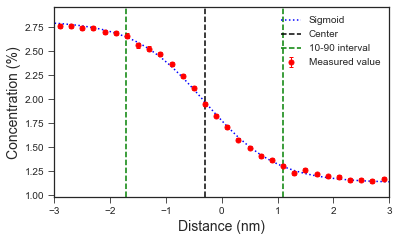

In [8]:
# interfacial width for all times we've experinced. 

times = ['Re_700_025h.csv', 'Re_700_1h.csv', 'Re_700_4h.csv', 'Re_700_16h.csv', 'Re_700_64h.csv', 'Re_700_256h.csv', 'Re_700_1024h.csv']

elements = ['Ni', 'Al', 'Cr', 'Re']
errors = ['Ni_Err', 'Al_Err', 'Cr_Err', 'Re_Err']

for i in times:
    # import csv data
    df= pd.read_csv(i)
    print ('\n\n\n', i)
    # maximun, Minimum, 90%, 10%, x-widthe using for-loop 
    for i, j in zip(elements, errors):
        # assigne x and y values
        x = df['distance'].to_numpy()
        y = df[i].to_numpy()
        y_err = df[j].to_numpy()
        print("\n Element", i)
        fit_sig(x, y, y_err)

## 5. Interfacial width with gaussian error range

In [9]:
# definition of sigmoid and gaussian fuctions
def fit_sig_gau(x, y, y_err):
    
    # nonlinear least squares curve fitting with sigmoid fuction

    OP= smodel.fit(y, params, bounds=([-20, -10, -0.7, 0], [20, 10, 0.7, 80]), x=x)

    #print parameters
    # print(OP.fit_report())
    print('-------------------------------')
    print('Parameter    Value       Stderr')
    for name, param in OP.params.items():
        print('{!s:7s} {:11.5f} {:11.5f}'.format(name, param.value, param.stderr))


    # define and print the y_max, y_min, y_90, and y_10 values
    y_max = OP.params['c'].value
    y_90 = OP.params['c'].value + 0.1*OP.params['h'].value
    y_10 = OP.params['c'].value + 0.9*OP.params['h'].value
    y_min = OP.params['c'].value + OP.params['h'].value
    print(f"y_max : {y_max:.3f}, y_90: {y_90:.3f},  y_10: {y_10:.3f},  y_min: {y_min:.3f}")

    # define sigmiod 90, 10% fuction.
    def fp(p) :
        f1 = sigmoid(p, OP.params['h'].value, OP.params['a'].value, OP.params['x0'].value, OP.params['c'].value) - y_90
        return f1

    def fq(q) :
        f2 = sigmoid(q, OP.params['h'].value, OP.params['a'].value, OP.params['x0'].value, OP.params['c'].value) - y_10
        return f2

    #Solving the equation (p=90%, q= 10%)
    p_sol = fsolve(fp,0)
    q_sol = fsolve(fq,0)
    x_gab = q_sol-p_sol

    R_squared = r2_score(OP.best_fit, y)
    print(f"x_90: {p_sol}, x_10: {q_sol}, x_gap: {x_gab}, R_2: {R_squared:.4f}")

    # gaussian process model setup
    # Trnasforse
    X = np.atleast_2d(x).T
    # Mesh the input space for evaluations of the real function, the prediction and
    # its MSE
    mesh = np.atleast_2d(np.linspace(-3, 3, 100)).T

    # Instantiate a Gaussian Process model
    kernel = RBF() + ConstantKernel(constant_value=2)
    gp = GaussianProcessRegressor(kernel=kernel, alpha=y_err ** 2,
                                  n_restarts_optimizer=10)

    # Fit to data using Maximum Likelihood Estimation of the parameters
    gp.fit(X, OP.best_fit)

    # Make the prediction on the meshed x-axis (ask for MSE as well)
    y_pred, sigma = gp.predict(mesh, return_std=True)

    # Plot the function, the prediction and the 95% confidence interval based on
    # the MSE
    plt.figure(figsize=(6,3.5))
    plt.plot(x, OP.best_fit, 'b:', label=r'Sigmoid')
    plt.errorbar(x, y, y_err, fmt='r.', markersize=10, elinewidth=1, capsize=2,label='Measured value')

    plt.fill(np.concatenate([mesh, mesh[::-1]]),
             np.concatenate([y_pred - 2 * sigma,
                            (y_pred + 2 * sigma)[::-1]]),
             alpha=.2, fc='b', ec='None', label='fitting 2-$\sigma$ band')

    plt.axvline(x=OP.params['x0'].value, color='k', linestyle='--', label='Center' )
    plt.axvline(x=p_sol, color='g', linestyle='--', label='10-90 interval')
    plt.axvline(x=q_sol, color='g', linestyle='--')
    plt.xlim([-3, 3])
    plt.legend(loc='best')
    plt.xlabel("Distance (nm)", fontsize=14)
    plt.ylabel('Concentration (%)', fontsize=14)
    plt.show()


# <end sigmoid fuction>

In [10]:
# import csv data
df0 = pd.read_csv('Re_700_1h.csv')
print("df0_shape :", df0.shape)
df = df0.iloc[0:40]
print("df_shape :", df.shape)

df0_shape : (27, 9)
df_shape : (27, 9)



 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -5.37083     0.12982
a           2.64564     0.20818
x0         -0.30340     0.03350
c          79.93524     0.10141
y_max : 79.935, y_90: 79.398,  y_10: 75.101,  y_min: 74.564
x_90: [-1.1339126], x_10: [0.52710341], x_gap: [1.66101601], R_2: 0.9933


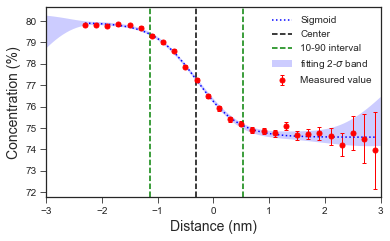


 Element Al
-------------------------------
Parameter    Value       Stderr
h          11.51540     0.15452
a           2.41710     0.10039
x0         -0.21812     0.01911
c           7.22380     0.11780
y_max : 7.224, y_90: 8.375,  y_10: 17.588,  y_min: 18.739
x_90: [-1.12715098], x_10: [0.69091432], x_gap: [1.8180653], R_2: 0.9981


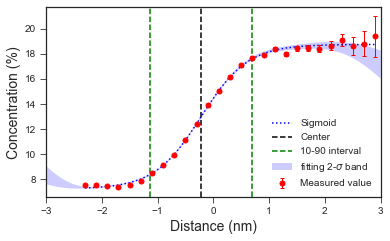


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -5.47735     0.06826
a           2.30632     0.08750
x0         -0.10915     0.01808
c          10.51353     0.05030
y_max : 10.514, y_90: 9.966,  y_10: 5.584,  y_min: 5.036
x_90: [-1.06184829], x_10: [0.84354631], x_gap: [1.9053946], R_2: 0.9984


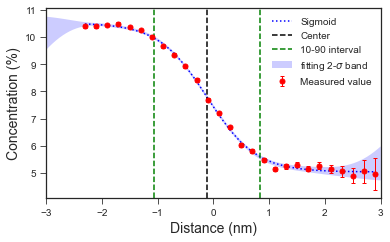


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -0.62671     0.02724
a           2.71320     0.38980
x0         -0.32043     0.05979
c           2.29015     0.02138
y_max : 2.290, y_90: 2.227,  y_10: 1.726,  y_min: 1.663
x_90: [-1.13025894], x_10: [0.48939946], x_gap: [1.6196584], R_2: 0.9779


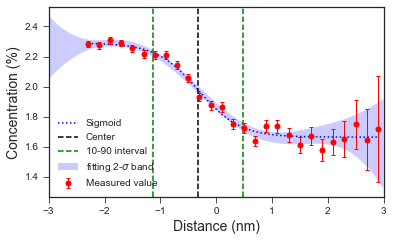

In [11]:
# maximun, Minimum, 90%, 10%, x-widthe using for-loop 
elements = ['Ni', 'Al', 'Cr', 'Re']
errors = ['Ni_Err', 'Al_Err', 'Cr_Err', 'Re_Err']
for i, j in zip(elements, errors):
    # assigne x and y values
    x = df['distance'].to_numpy()
    y = df[i].to_numpy()
    y_err = df[j].to_numpy()
    print("\n Element", i)
    fit_sig_gau(x, y, y_err)

## 5. Obtain the interfacial width for all aging times using the for-loop




 Re_700_025h.csv

 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -5.26133     0.11209
a           2.49764     0.16157
x0         -0.11963     0.02999
c          78.89532     0.04400
y_max : 78.895, y_90: 78.369,  y_10: 74.160,  y_min: 73.634
x_90: [-0.99935508], x_10: [0.76008799], x_gap: [1.75944308], R_2: 0.9950


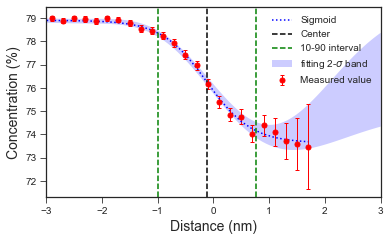


 Element Al
-------------------------------
Parameter    Value       Stderr
h           9.69319     0.15751
a           2.41001     0.11691
x0         -0.15531     0.02325
c           9.43218     0.06221
y_max : 9.432, y_90: 10.401,  y_10: 18.156,  y_min: 19.125
x_90: [-1.06701372], x_10: [0.75639953], x_gap: [1.82341326], R_2: 0.9971


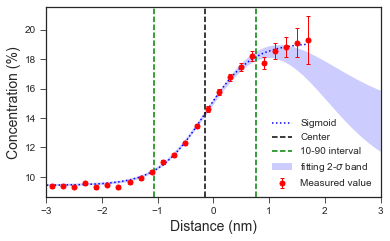


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -3.74339     0.09226
a           2.37160     0.17748
x0         -0.25118     0.03613
c           9.47440     0.03858
y_max : 9.474, y_90: 9.100,  y_10: 6.105,  y_min: 5.731
x_90: [-1.17765577], x_10: [0.67529368], x_gap: [1.85294945], R_2: 0.9932


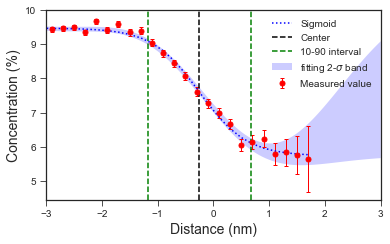


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -0.64825     0.03344
a           2.77159     0.44883
x0          0.02264     0.06826
c           2.19346     0.01253
y_max : 2.193, y_90: 2.129,  y_10: 1.610,  y_min: 1.545
x_90: [-0.77012588], x_10: [0.81540735], x_gap: [1.58553323], R_2: 0.9694


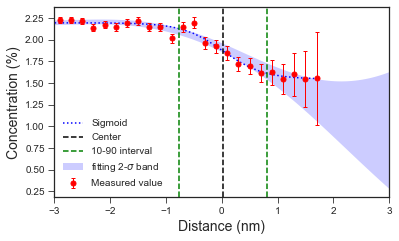




 Re_700_1h.csv

 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -5.37083     0.12982
a           2.64564     0.20818
x0         -0.30340     0.03350
c          79.93524     0.10141
y_max : 79.935, y_90: 79.398,  y_10: 75.101,  y_min: 74.564
x_90: [-1.1339126], x_10: [0.52710341], x_gap: [1.66101601], R_2: 0.9933


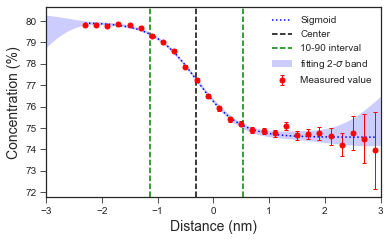


 Element Al
-------------------------------
Parameter    Value       Stderr
h          11.51540     0.15452
a           2.41710     0.10039
x0         -0.21812     0.01911
c           7.22380     0.11780
y_max : 7.224, y_90: 8.375,  y_10: 17.588,  y_min: 18.739
x_90: [-1.12715098], x_10: [0.69091432], x_gap: [1.8180653], R_2: 0.9981


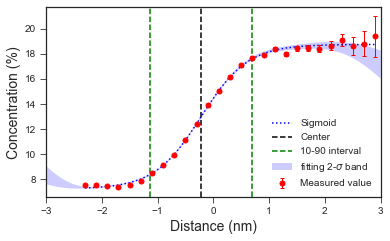


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -5.47735     0.06826
a           2.30632     0.08750
x0         -0.10915     0.01808
c          10.51353     0.05030
y_max : 10.514, y_90: 9.966,  y_10: 5.584,  y_min: 5.036
x_90: [-1.06184829], x_10: [0.84354631], x_gap: [1.9053946], R_2: 0.9984


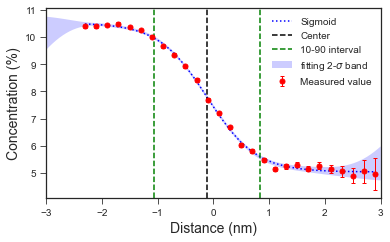


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -0.62671     0.02724
a           2.71320     0.38980
x0         -0.32043     0.05979
c           2.29015     0.02138
y_max : 2.290, y_90: 2.227,  y_10: 1.726,  y_min: 1.663
x_90: [-1.13025894], x_10: [0.48939946], x_gap: [1.6196584], R_2: 0.9779


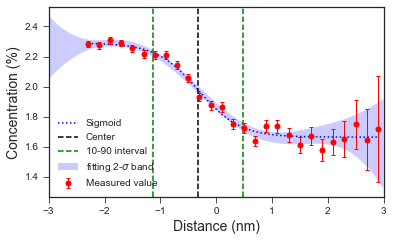




 Re_700_4h.csv

 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -5.31093     0.07673
a           2.82377     0.14867
x0         -0.15224     0.02104
c          80.20169     0.05606
y_max : 80.202, y_90: 79.671,  y_10: 75.422,  y_min: 74.891
x_90: [-0.93036004], x_10: [0.62587371], x_gap: [1.55623375], R_2: 0.9970


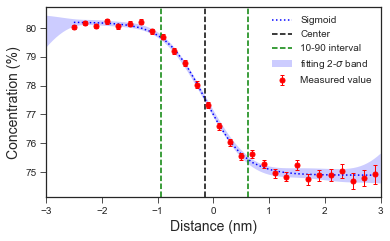


 Element Al
-------------------------------
Parameter    Value       Stderr
h          12.52184     0.12001
a           2.53107     0.08138
x0         -0.20830     0.01420
c           6.21188     0.08860
y_max : 6.212, y_90: 7.464,  y_10: 17.482,  y_min: 18.734
x_90: [-1.0764015], x_10: [0.65980205], x_gap: [1.73620355], R_2: 0.9988


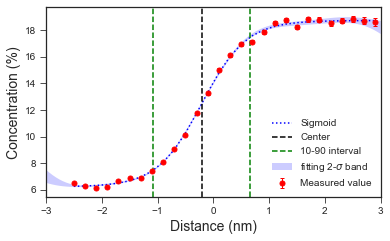


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -6.09278     0.08500
a           2.33582     0.10303
x0         -0.21584     0.02090
c          11.08143     0.06265
y_max : 11.081, y_90: 10.472,  y_10: 5.598,  y_min: 4.989
x_90: [-1.15650586], x_10: [0.72482272], x_gap: [1.88132858], R_2: 0.9978


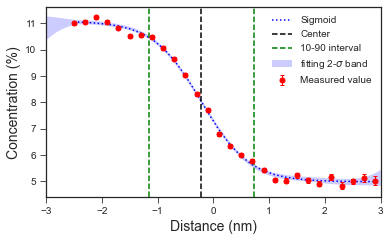


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -1.16210     0.03023
a           2.34952     0.18355
x0         -0.50453     0.03740
c           2.54610     0.02405
y_max : 2.546, y_90: 2.430,  y_10: 1.500,  y_min: 1.384
x_90: [-1.43971319], x_10: [0.43064623], x_gap: [1.87035943], R_2: 0.9930


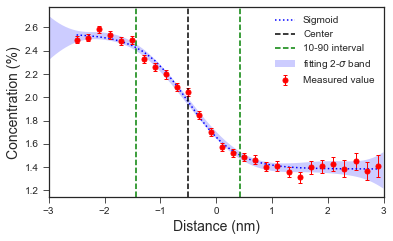




 Re_700_16h.csv

 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -4.77248     0.06092
a           3.20934     0.17963
x0          0.03238     0.01997
c          79.95614     0.04074
y_max : 79.956, y_90: 79.479,  y_10: 75.661,  y_min: 75.184
x_90: [-0.65225338], x_10: [0.71701484], x_gap: [1.36926822], R_2: 0.9967


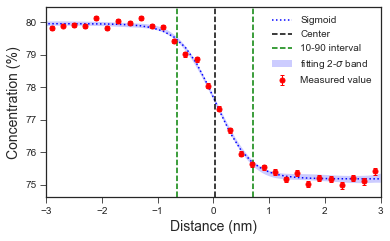


 Element Al
-------------------------------
Parameter    Value       Stderr
h          12.30840     0.06649
a           2.54905     0.05212
x0         -0.00679     0.00906
c           5.77193     0.04403
y_max : 5.772, y_90: 7.003,  y_10: 16.849,  y_min: 18.080
x_90: [-0.86877128], x_10: [0.85518235], x_gap: [1.72395363], R_2: 0.9995


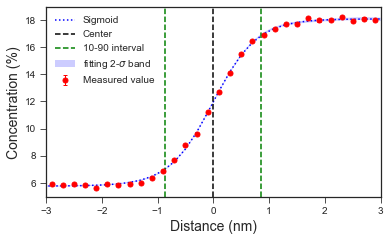


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -6.22513     0.02960
a           2.24626     0.03712
x0         -0.01096     0.00820
c          11.60280     0.01934
y_max : 11.603, y_90: 10.980,  y_10: 6.000,  y_min: 5.378
x_90: [-0.98913408], x_10: [0.9672042], x_gap: [1.95633828], R_2: 0.9996


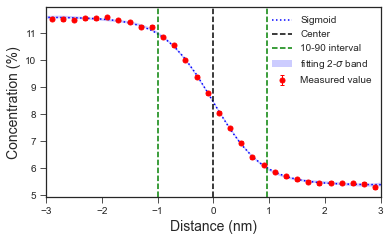


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -1.37110     0.01978
a           1.99741     0.09177
x0         -0.19098     0.02521
c           2.71350     0.01346
y_max : 2.714, y_90: 2.576,  y_10: 1.480,  y_min: 1.342
x_90: [-1.29101691], x_10: [0.90905144], x_gap: [2.20006835], R_2: 0.9971


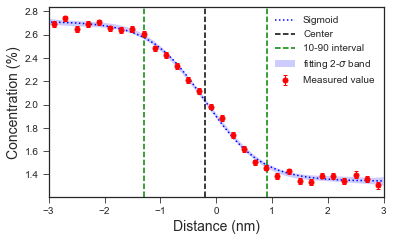




 Re_700_64h.csv

 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -4.63225     0.03392
a           3.45905     0.13426
x0         -0.40611     0.01291
c          80.14281     0.02441
y_max : 80.143, y_90: 79.680,  y_10: 75.974,  y_min: 75.511
x_90: [-1.04132315], x_10: [0.22909661], x_gap: [1.27041976], R_2: 0.9984


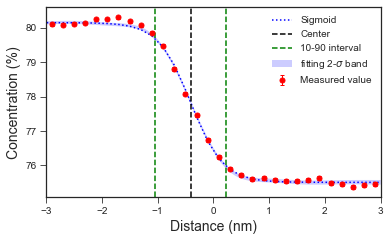


 Element Al
-------------------------------
Parameter    Value       Stderr
h          12.19063     0.02178
a           2.53479     0.01982
x0         -0.52337     0.00353
c           5.69109     0.01582
y_max : 5.691, y_90: 6.910,  y_10: 16.663,  y_min: 17.882
x_90: [-1.39020099], x_10: [0.34345506], x_gap: [1.73365604], R_2: 0.9999


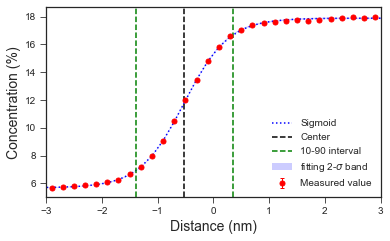


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -6.10156     0.01421
a           2.14874     0.01991
x0         -0.20651     0.00490
c          11.45896     0.00967
y_max : 11.459, y_90: 10.849,  y_10: 5.968,  y_min: 5.357
x_90: [-1.22907341], x_10: [0.81605572], x_gap: [2.04512913], R_2: 0.9999


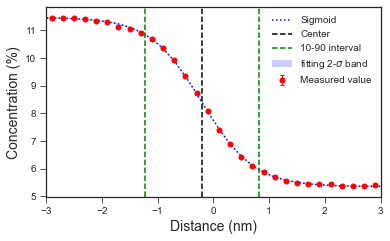


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -1.56040     0.00832
a           1.89780     0.03694
x0         -0.36161     0.01154
c           2.80554     0.00578
y_max : 2.806, y_90: 2.650,  y_10: 1.401,  y_min: 1.245
x_90: [-1.5193885], x_10: [0.79616549], x_gap: [2.315554], R_2: 0.9994


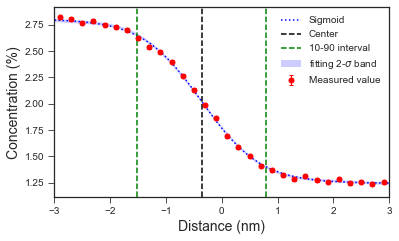




 Re_700_256h.csv

 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -4.34139     0.04241
a           4.63338     0.32437
x0          0.06428     0.01735
c          80.12384     0.02930
y_max : 80.124, y_90: 79.690,  y_10: 76.217,  y_min: 75.782
x_90: [-0.40993307], x_10: [0.53850062], x_gap: [0.94843369], R_2: 0.9959


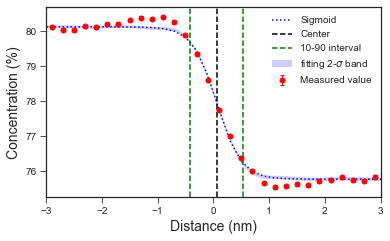


 Element Al
-------------------------------
Parameter    Value       Stderr
h          12.08908     0.01389
a           2.76694     0.01706
x0         -0.00636     0.00256
c           5.50212     0.00954
y_max : 5.502, y_90: 6.711,  y_10: 16.382,  y_min: 17.591
x_90: [-0.80046003], x_10: [0.7877357], x_gap: [1.58819572], R_2: 0.9999


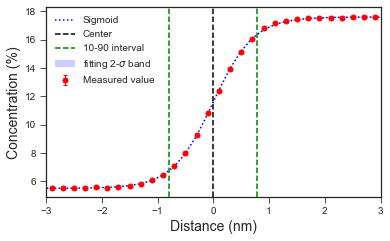


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -6.24017     0.01060
a           2.07298     0.01591
x0         -0.04973     0.00424
c          11.64385     0.00722
y_max : 11.644, y_90: 11.020,  y_10: 6.028,  y_min: 5.404
x_90: [-1.10966325], x_10: [1.01020984], x_gap: [2.11987309], R_2: 0.9999


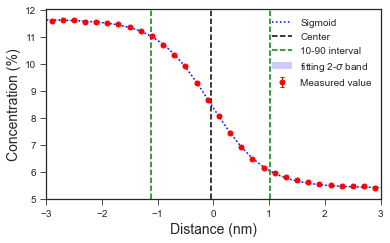


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -1.66692     0.00565
a           1.70711     0.02312
x0         -0.21097     0.00902
c           2.83930     0.00390
y_max : 2.839, y_90: 2.673,  y_10: 1.339,  y_min: 1.172
x_90: [-1.49806513], x_10: [1.07613169], x_gap: [2.57419682], R_2: 0.9996


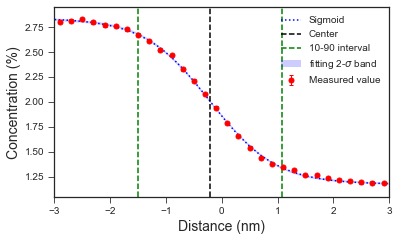




 Re_700_1024h.csv

 Element Ni
-------------------------------
Parameter    Value       Stderr
h          -4.42920     0.04743
a           4.57293     0.34857
x0         -0.03472     0.01914
c          80.13322     0.03313
y_max : 80.133, y_90: 79.690,  y_10: 76.147,  y_min: 75.704
x_90: [-0.51520138], x_10: [0.44576858], x_gap: [0.96096996], R_2: 0.9951


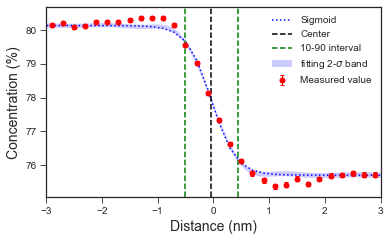


 Element Al
-------------------------------
Parameter    Value       Stderr
h          12.25446     0.02019
a           2.70628     0.02362
x0         -0.08291     0.00371
c           5.46770     0.01399
y_max : 5.468, y_90: 6.693,  y_10: 16.497,  y_min: 17.722
x_90: [-0.89480515], x_10: [0.72899464], x_gap: [1.6237998], R_2: 0.9999


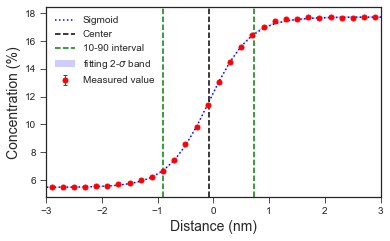


 Element Cr
-------------------------------
Parameter    Value       Stderr
h          -6.32328     0.01735
a           2.00513     0.02435
x0         -0.09988     0.00694
c          11.70276     0.01188
y_max : 11.703, y_90: 11.070,  y_10: 6.012,  y_min: 5.379
x_90: [-1.19568194], x_10: [0.99592398], x_gap: [2.19160592], R_2: 0.9997


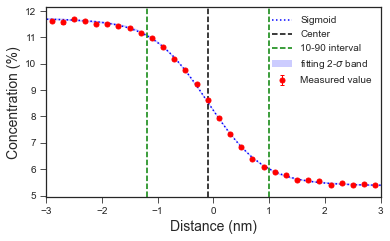


 Element Re
-------------------------------
Parameter    Value       Stderr
h          -1.69039     0.00877
a           1.56561     0.03058
x0         -0.30400     0.01410
c           2.81773     0.00609
y_max : 2.818, y_90: 2.649,  y_10: 1.296,  y_min: 1.127
x_90: [-1.70743242], x_10: [1.09942918], x_gap: [2.8068616], R_2: 0.9992


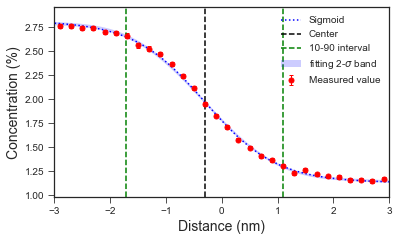

In [12]:

# interfacial width for all times we've experinced. 

times = ['Re_700_025h.csv', 'Re_700_1h.csv', 'Re_700_4h.csv', 'Re_700_16h.csv', 'Re_700_64h.csv', 'Re_700_256h.csv', 'Re_700_1024h.csv']

elements = ['Ni', 'Al', 'Cr', 'Re']
errors = ['Ni_Err', 'Al_Err', 'Cr_Err', 'Re_Err']

for i in times:
    # import csv data
    df= pd.read_csv(i)
    print ('\n\n\n', i)
    # maximun, Minimum, 90%, 10%, x-widthe using for-loop 
    for i, j in zip(elements, errors):
        # assigne x and y values
        x = df['distance'].to_numpy()
        y = df[i].to_numpy()
        y_err = df[j].to_numpy()
        print("\n Element", i)
        fit_sig_gau(x, y, y_err)
        

In [13]:
x = df['distance'].to_numpy()
y = df['Ni'].to_numpy()
y_err = df['Ni_Err'].to_numpy()
params = smodel.make_params(h=5, a=1, x0=0, c=10)
OP= smodel.fit(y, params, bounds=([-20, -10, -1, 0], [20, 10, 1, 80]), x=x)
print(OP.fit_report())

# print(result.fit_report())
print('-------------------------------')
print('Parameter    Value       Stderr')
for name, param in OP.params.items():
    print('{:7s} {:11.5f} {:11.5f}'.format(name, param.value, param.stderr))

[[Model]]
    Model(sigmoid)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 64
    # data points      = 52
    # variables        = 4
    chi-square         = 1.14847664
    reduced chi-square = 0.02392660
    Akaike info crit   = -190.265980
    Bayesian info crit = -182.461005
[[Variables]]
    h:  -4.42920300 +/- 0.04743297 (1.07%) (init = 5)
    a:   4.57293083 +/- 0.34856878 (7.62%) (init = 1)
    x0: -0.03471640 +/- 0.01913726 (55.12%) (init = 0)
    c:   80.1332202 +/- 0.03313097 (0.04%) (init = 10)
[[Correlations]] (unreported correlations are < 0.100)
    C(h, c)  = -0.721
    C(h, a)  =  0.327
    C(x0, c) = -0.248
    C(a, c)  = -0.236
-------------------------------
Parameter    Value       Stderr
h          -4.42920     0.04743
a           4.57293     0.34857
x0         -0.03472     0.01914
c          80.13322     0.03313
